# SI Outbreaks checks

Here's a notebook to compute SI outbreaks on graphs numerically and compare with the analytical results presented in https://arxiv.org/pdf/2102.11708.pdf eqn (93) for trees and eqn (106) for the cycle graph. 

In [36]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.special as sc
import networkx as nx
import math

susceptible = "S"
infected = "I"

def initialize_chain(populationSize):
    '''
    Initializes the chain graph of size 'populationSize' such that the first node is infected 
    and all others are susceptible. 
    
    Defines a nx graph 'network' and a copy this graph as 'nextNetwork' 
    '''
    
    global network, nextNetwork

    network = nx.path_graph(populationSize)
    #nx.erdos_renyi_graph(populationSize, linkProbability)

    for i in network.nodes:
        network.nodes[i]['state'] = susceptible

    network.nodes[0]['state'] = infected
    
    nextNetwork = network.copy()

def initialize_cycle(populationSize):
    '''
    Initializes the cycle graph of size 'populationSize' such that the first node is infected 
    and all others are susceptible. 
    
    Defines a nx graph 'network' and a copy this graph as 'nextNetwork' 
    '''
    global network, nextNetwork

    network = nx.cycle_graph(populationSize)
    #nx.erdos_renyi_graph(populationSize, linkProbability)

    for i in network.nodes:
        network.nodes[i]['state'] = susceptible

    network.nodes[0]['state'] = infected
    
    nextNetwork = network.copy()

def update(infectionProb):
    '''
    Defines the dynamics of a single time-step. Each susceptible node neighboring an infected 
    becomes infected with probability 'infectionProb'
    
    Updates the globally defined nx.graphs 'network' and 'nextNetwork'
    '''
    global network, nextNetwork

    for i in network.nodes:
        if network.nodes[i]['state'] == susceptible:
            nextNetwork.nodes[i]['state'] = susceptible
            for j in network.neighbors(i):
                if network.nodes[j]['state'] == infected:
                    if random.random() < infectionProb:
                        nextNetwork.nodes[i]['state'] = infected
                        break
        else:
            nextNetwork.nodes[i]['state'] = infected

    network, nextNetwork = nextNetwork, network

def run_sim(tmax,infectionProb):
    '''
    Runs the simulation until timestep 'tmax' with infection probability 'infectionProb'
    
    Defines two lists 'stot' and 'itot' containing the total number of susceptible and infected
    in the network at each timestep
    '''
       
    itot=[]
    
    for t in range(tmax) :
        icount=0
        for i in network.nodes:
            if network.nodes[i]['state'] == infected:
                icount += 1

        itot.append(icount)
        
        #if scount==0:
        #    break
        update(infectionProb)
    
    return itot

def mc_chain(populationSize,tmax,tau,nruns):
    '''
    Monte Carlo of the SI outbreak on a chain of size "populationSize" for 'tmax' timesteps 
    and 'nruns' number of runs. The infection probability 'tau' plays the role of delta t.
    
    Defines the lists 'sav' and 'iav' containing the average number of susceptible and infected
    at each timestep. 
    
    Defines the list 'istd' containing the standard deviation of the number of infected at each
    timestep
    '''
    global istd
    
    ilist=[]
        
    for i in range(nruns):
        initialize_chain(populationSize)
        ilist.append(run_sim(tmax,tau))
    
    
    iav = np.mean(np.array(ilist), axis=0)
    istd = np.std(np.array(ilist), axis=0)
    
    return iav
    
    
def mc_cycle(populationSize,tmax,tau,nruns):
    '''
    Monte Carlo of the SI outbreak on a cycle of size "populationSize" for 'tmax' timesteps 
    and 'nruns' number of runs. The infection probability 'tau' plays the role of delta t.
    
    Defines the lists 'sav' and 'iav' containing the average number of susceptible and infected
    at each timestep. 
    
    Defines the list 'istd' containing the standard deviation of the number of infected at each
    timestep
    '''
    global istd
    
    ilist=[]
        
    for i in range(nruns):
        initialize_cycle(populationSize)
        ilist.append(run_sim(tmax,tau))
    
    
    iav = np.mean(np.array(ilist), axis=0)
    istd = np.std(np.array(ilist), axis=0)
    
    return iav

def Nd(d):
    nd=1+3*(2**d-1)
    return int(nd)

def initialize_tree(d):
    '''
    Initializes a regular tree graph of degree 3 and length 'd' such that the center node is infected 
    and all others are susceptible. 
    
    Defines a nx graph 'network' and a copy this graph as 'nextNetwork' 
    '''
    
    global network, nextNetwork

    network = nx.Graph()
    network.add_node(0)
    for i in range(3):
        network.add_edge(0,i+1)
    
    for k in range(d-1):
        for i in range(3*2**(k+1)):
            network.add_edge(int(Nd(k)+i/2),Nd(k+1)+i)
    
    for i in network.nodes:
        network.nodes[i]['state'] = susceptible

    network.nodes[0]['state'] = infected
    
    nextNetwork = network.copy()

def mc_tree(d,tmax,tau,nruns):
    '''
    Monte Carlo of the SI outbreak on a regular tree with length 'd' for 'tmax' timesteps 
    and 'nruns' number of runs. The infection probability 'tau' plays the role of delta t.
    
    Defines the lists 'sav' and 'iav' containing the average number of susceptible and infected
    at each timestep. 
    
    Defines the list 'istd' containing the standard deviation of the number of infected at each
    timestep
    '''
    global istd
    
    ilist=[]
        
    for i in range(nruns):
        initialize_tree(d)
        ilist.append(run_sim(tmax,tau))
    
    
    iav = np.mean(np.array(ilist), axis=0)
    istd = np.std(np.array(ilist), axis=0)
    
    return iav

#Analytical expressions to compare with. 
#Equation (93) with k0=k1=3 for the tree with maximal distance 'd'
def ytree(d):
    global t
    y = 1+sum([3*2**k*(1-sc.gammaincc(k+1,t)) for k in range(d)])
    
    return y

#Analytical expressions to compare with. 
#Equation (106) for the cycle graph of N nodes
def ycycle(N):
    global t
    
    y = (1-(2**N*t**N*math.e**(-2*t))/math.factorial(N) + (1-N+2*t)*(sc.gammaincc(N,2*t))/N)
    return y

In [15]:
def pointsforplots(iav,N,tau):
    global seltimes, t
    
    seltimes=[int(i/tau) for i in range(int(len(iav)*tau))]
    
    isel=[iav[i]/N for i in seltimes]
    tsel=[t[i] for i in seltimes]
    
    return tsel, isel

Cycle graph for N=5,10,15,20,15,30

In [53]:
tau=0.02
tmax=15
nsim=4000
t = np.linspace(0,tmax,int(tmax/tau))

iC5=mc_cycle(5,int(tmax/tau),tau,nsim)
iC10=mc_cycle(10,int(tmax/tau),tau,nsim)
iC15=mc_cycle(15,int(tmax/tau),tau,nsim)
iC20=mc_cycle(20,int(tmax/tau),tau,nsim)
iC25=mc_cycle(25,int(tmax/tau),tau,nsim)
iC30=mc_cycle(30,int(tmax/tau),tau,nsim)

In [54]:
iplotC5=pointsforplots(iC5,5,tau)
iplotC10=pointsforplots(iC10,10,tau)
iplotC15=pointsforplots(iC15,15,tau)
iplotC20=pointsforplots(iC20,20,tau)
iplotC25=pointsforplots(iC25,25,tau)
iplotC30=pointsforplots(iC30,30,tau)

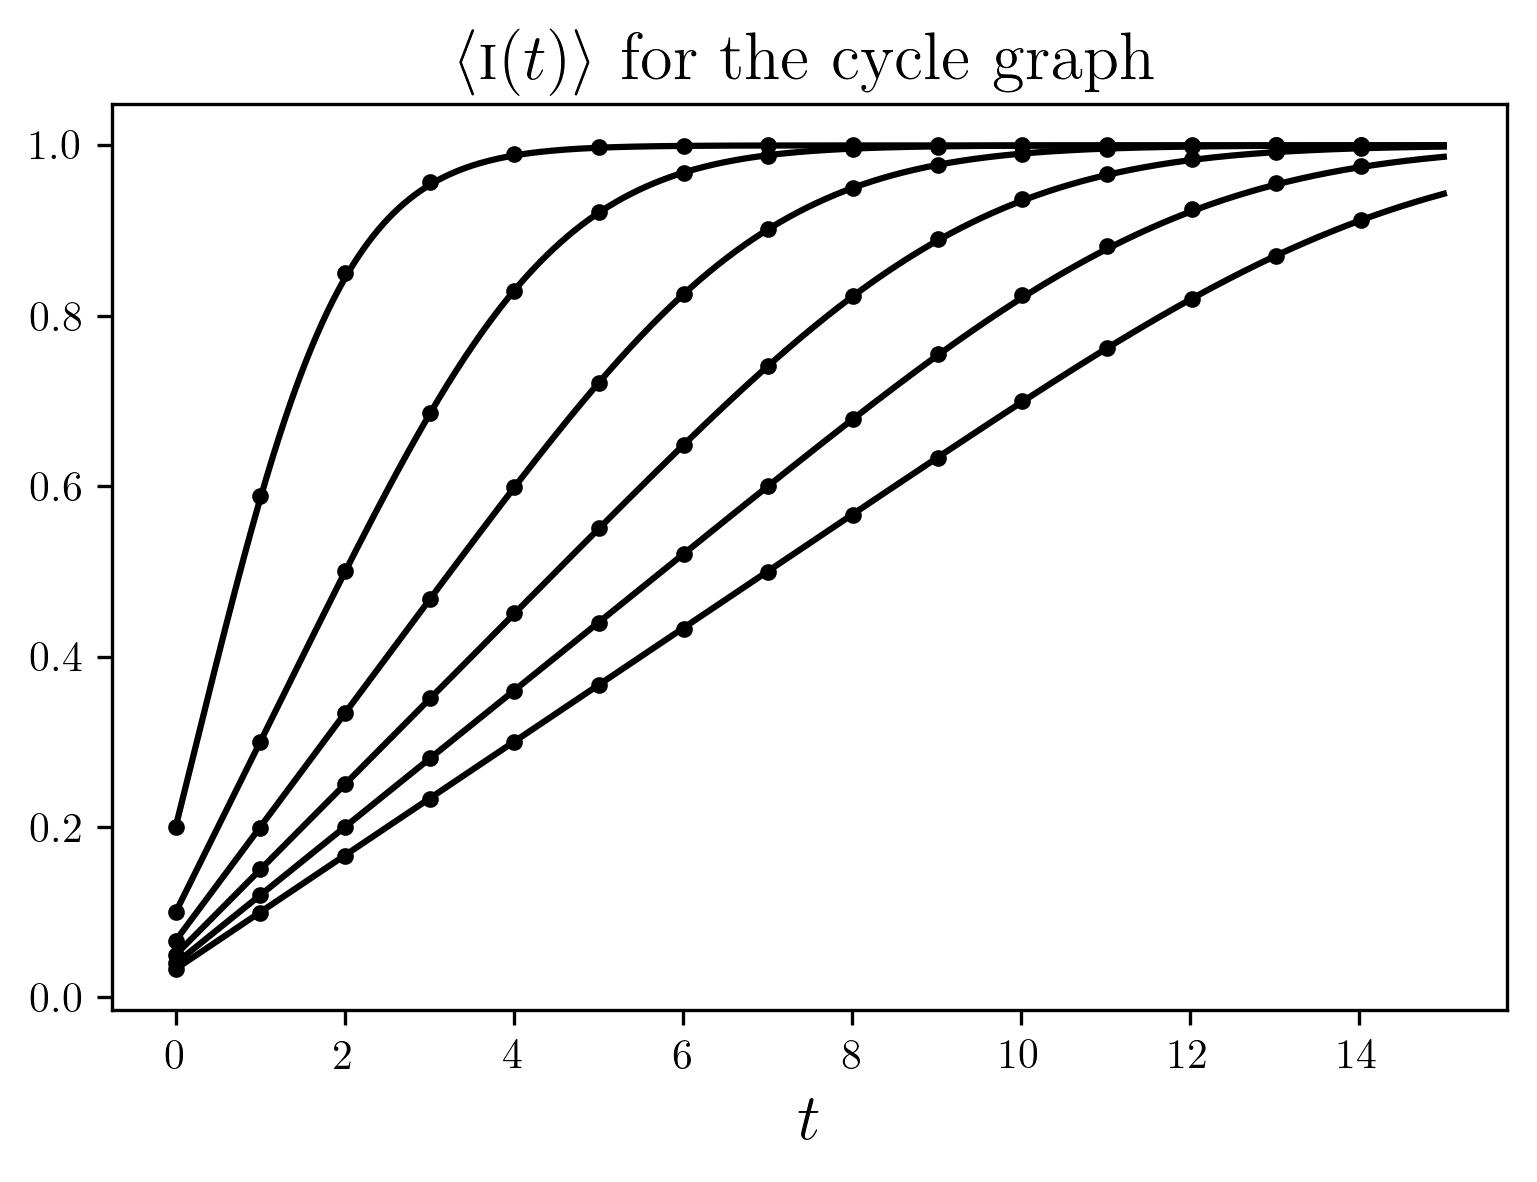

In [75]:
plt.figure(dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(6):
    plt.plot(t, ycycle(5*(i+1)),'k')

plt.plot(iplotC5[0],iplotC5[1],'k.')
plt.plot(iplotC10[0],iplotC10[1],'k.')
plt.plot(iplotC15[0],iplotC15[1],'k.')
plt.plot(iplotC20[0],iplotC20[1],'k.')
plt.plot(iplotC25[0],iplotC25[1],'k.')
plt.plot(iplotC30[0],iplotC30[1],'k.')
plt.title(r'$\langle \textsc{i}(t) \rangle$ for the cycle graph',size=16)
#plt.ylabel(r'$\langle \textsc{i}(t) \rangle$')
plt.xlabel(r'$t$',size=16)
plt.show()

Now let's do the trees!

In [76]:
tau=0.02
tmax=15
nsim=4000
t = np.linspace(0,tmax,int(tmax/tau))

iT2=mc_tree(2,int(tmax/tau),tau,nsim)
iplotT2=pointsforplots(iT2,Nd(2),tau)
iT3=mc_tree(3,int(tmax/tau),tau,nsim)
iplotT3=pointsforplots(iT3,Nd(3),tau)
iT4=mc_tree(4,int(tmax/tau),tau,nsim)
iplotT4=pointsforplots(iT4,Nd(4),tau)
iT5=mc_tree(5,int(tmax/tau),tau,nsim)
iplotT5=pointsforplots(iT5,Nd(5),tau)
iT6=mc_tree(6,int(tmax/tau),tau,nsim)
iplotT6=pointsforplots(iT6,Nd(6),tau)
iT7=mc_tree(7,int(tmax/tau),tau,nsim)
iplotT7=pointsforplots(iT7,Nd(7),tau)
iT8=mc_tree(8,int(tmax/tau),tau,nsim)
iplotT8=pointsforplots(iT8,Nd(8),tau)

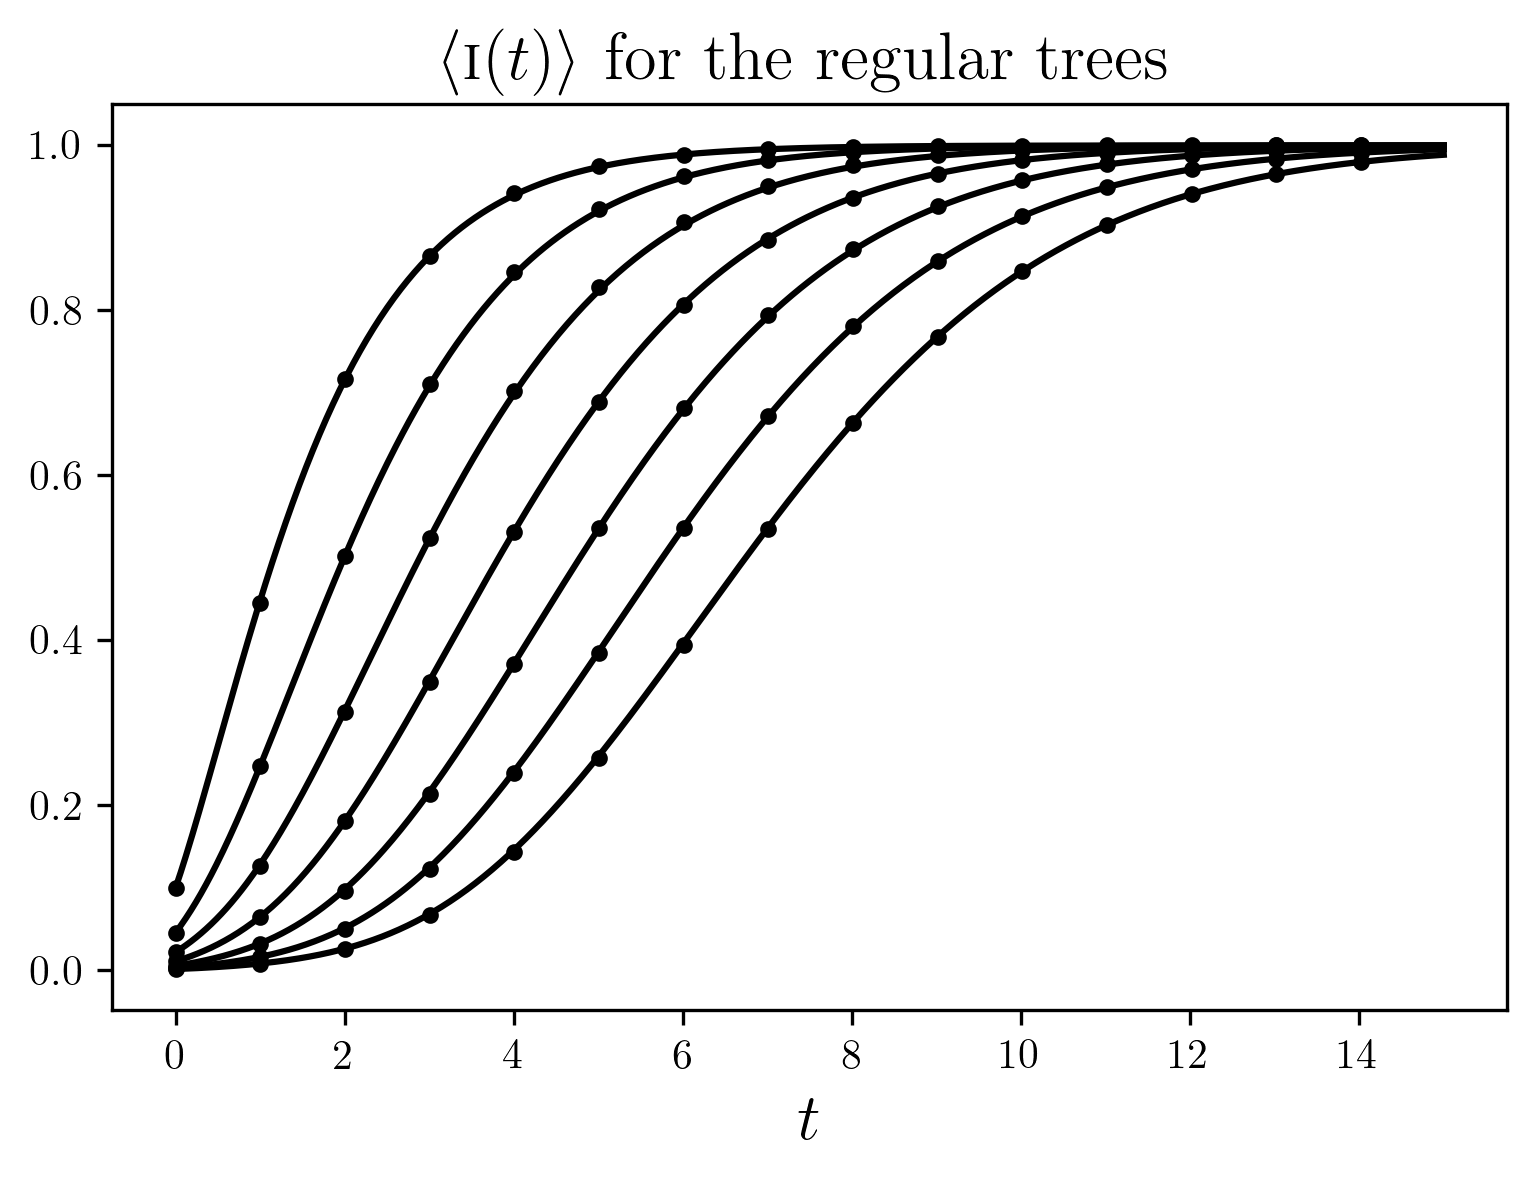

In [77]:
plt.figure(dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(7):
    plt.plot(t, ytree(i+2)/Nd(i+2),'k')

plt.plot(iplotT2[0],iplotT2[1],'k.')
plt.plot(iplotT3[0],iplotT3[1],'k.')
plt.plot(iplotT4[0],iplotT4[1],'k.')
plt.plot(iplotT5[0],iplotT5[1],'k.')
plt.plot(iplotT6[0],iplotT6[1],'k.')
plt.plot(iplotT7[0],iplotT7[1],'k.')
plt.plot(iplotT8[0],iplotT8[1],'k.')
plt.title(r'$\langle \textsc{i}(t) \rangle$ for the regular trees',size=16)
#plt.ylabel(r'$\langle \textsc{i}(t) \rangle$')
plt.xlabel(r'$t$',size=16)
plt.show()